In [16]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import ot.plot

from utils import *

In [17]:
# Load two real signals

sr = 44100
duration = 1.5
frames = np.arange(duration * sr) / sr

smooth_len = 1000
smoothing = np.linspace(0, 1, smooth_len)

A_signal, sr = librosa.load('sounds/real/A.wav', sr=44100, duration=duration)
A_signal[:smooth_len] *= smoothing
A_signal[-smooth_len:] *= np.flip(smoothing)
C_signal, _ = librosa.load('sounds/real/C.wav', sr=44100, duration=duration)
C_signal[:smooth_len] *= smoothing
C_signal[-smooth_len:] *= np.flip(smoothing)


## Using ffts

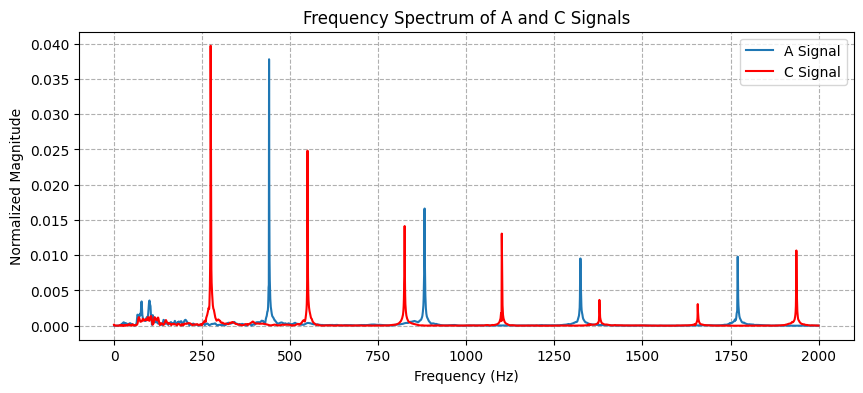

In [18]:

A_fft = np.fft.rfft(A_signal)
C_fft = np.fft.fft(C_signal)
fft_frequency = np.fft.fftfreq(len(A_signal), d=1/sr)
fft_frequency = fft_frequency[:len(fft_frequency) // 2]
n = len(fft_frequency)

# Take the magnitude of the FFT and normalize it
A_fft_magnitude = np.abs(A_fft)[:n]
A_fft_magnitude /= np.sum(A_fft_magnitude)
C_fft_magnitude = np.abs(C_fft)[:n]
C_fft_magnitude /= np.sum(C_fft_magnitude)


max_frequency_index = 2000 # in Hz, for plotting 
index = np.argmax(fft_frequency > max_frequency_index)

plt.figure(figsize=[10, 4])

# Use line plots for a cleaner look
plt.plot(fft_frequency[:index], A_fft_magnitude[:index], label='A Signal', linewidth=1.5)
plt.plot(fft_frequency[:index], C_fft_magnitude[:index], label='C Signal', color='red', linewidth=1.5)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Magnitude')
plt.title('Frequency Spectrum of A and C Signals')
plt.grid(True, which="both", ls="--")
plt.legend()

plt.show()

In [19]:
# Optimal transport

alpha = 0.5

# Quantile method 

fft_quantile_interpolation = quantile_optimal_transport(A_fft_magnitude, C_fft_magnitude, alpha=alpha)

# EMD 

fft_emd_interpolation = emd_optimal_transport(fft_frequency, A_fft_magnitude, C_fft_magnitude, alpha=alpha)


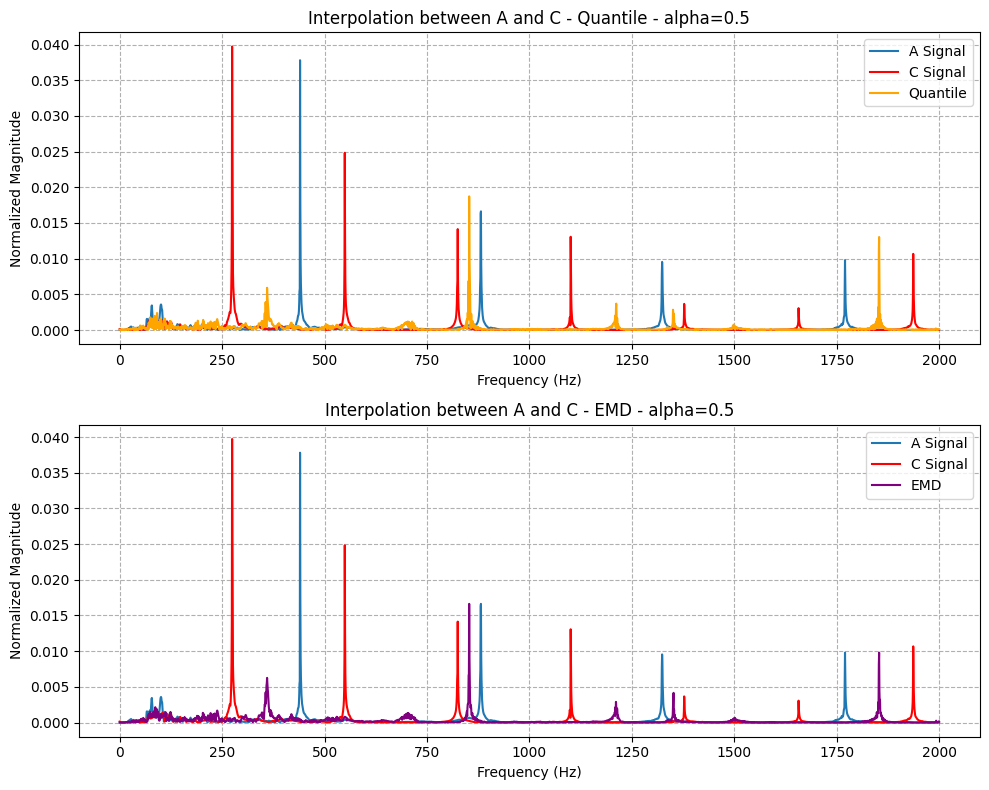

In [20]:
max_frequency_index = 2000 # in Hz, for plotting 
index = np.argmax(fft_frequency > max_frequency_index)

plt.figure(figsize=[10, 8])  # Increase figure size to accommodate both subplots

# First subplot for A, C, and quantile interpolation
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
plt.plot(fft_frequency[:index], A_fft_magnitude[:index], label='A Signal', linewidth=1.5)
plt.plot(fft_frequency[:index], C_fft_magnitude[:index], label='C Signal', color='red', linewidth=1.5)
plt.plot(fft_frequency[:index], fft_quantile_interpolation[:index], label='Quantile', color="orange")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Magnitude')
plt.title(f'Interpolation between A and C - Quantile - alpha={alpha}')
plt.grid(True, which="both", ls="--")
plt.legend()

# Second subplot for A, C, and EMD interpolation
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
plt.plot(fft_frequency[:index], A_fft_magnitude[:index], label='A Signal', linewidth=1.5)
plt.plot(fft_frequency[:index], C_fft_magnitude[:index], label='C Signal', color='red', linewidth=1.5)
plt.plot(fft_frequency[:index], fft_emd_interpolation[:index], label='EMD', color="purple")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Magnitude')
plt.title(f'Interpolation between A and C - EMD - alpha={alpha}')
plt.grid(True, which="both", ls="--")
plt.legend()

plt.tight_layout()  # Adjust the layout so the plots are neatly arranged
plt.show()

In [21]:
fft_quantile_inversed = np.fft.ifft(fft_quantile_interpolation)
fft_emd_inversed = np.fft.ifft(fft_emd_interpolation)

fft_signals = [A_signal, C_signal, fft_quantile_inversed, fft_emd_inversed]
fft_titles = ['A', 'C', f'Quantile interpolation - alpha={alpha}', f'EMD interpolation - alpha={alpha}']
audio_widgets = [audio_widget(signal, title) for signal, title in zip(fft_signals, fft_titles)]

grid = widgets.VBox(audio_widgets)
grid

/Users/davidvaldivia/IASD/memoire/audio_ot/audio_1D_transport/.venv/lib/python3.9/site-packages/IPython/lib/display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


## Using STFTs

In [22]:
from math import log2, ceil

window_size = 20 # ms
window_size_samples = window_size * 1e-3 * sr
n_fft = 2 ** ceil(log2(window_size_samples))
A_stft = librosa.stft(A_signal, n_fft=n_fft)
C_stft = librosa.stft(C_signal, n_fft=n_fft)

stft_frequency = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

In [23]:
# Optimal transport

alpha = 0.5
n_frames = A_stft.shape[1]

stft_quantile_interpolation = np.zeros_like(A_stft)
stft_emd_interpolation = np.zeros_like(A_stft)

for frame in range(n_frames):

    A_frame, A_frame_relative_amplitude = normalized_frame(A_stft, frame)
    C_frame, C_frame_relative_amplitude = normalized_frame(C_stft, frame)

    interpolated_frame_relative_amplitude = (1-alpha) * A_frame_relative_amplitude + alpha * C_frame_relative_amplitude

    stft_quantile_interpolation[:, frame] = quantile_optimal_transport(A_frame, C_frame, alpha=alpha) * interpolated_frame_relative_amplitude

    stft_emd_interpolation[:, frame] = emd_optimal_transport(stft_frequency, A_frame, C_frame, alpha=alpha) * interpolated_frame_relative_amplitude


/var/folders/3q/fky9tlbn3_qfz7hw6cxpgdv40000gp/T/ipykernel_7563/1310150362.py:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  img = librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),


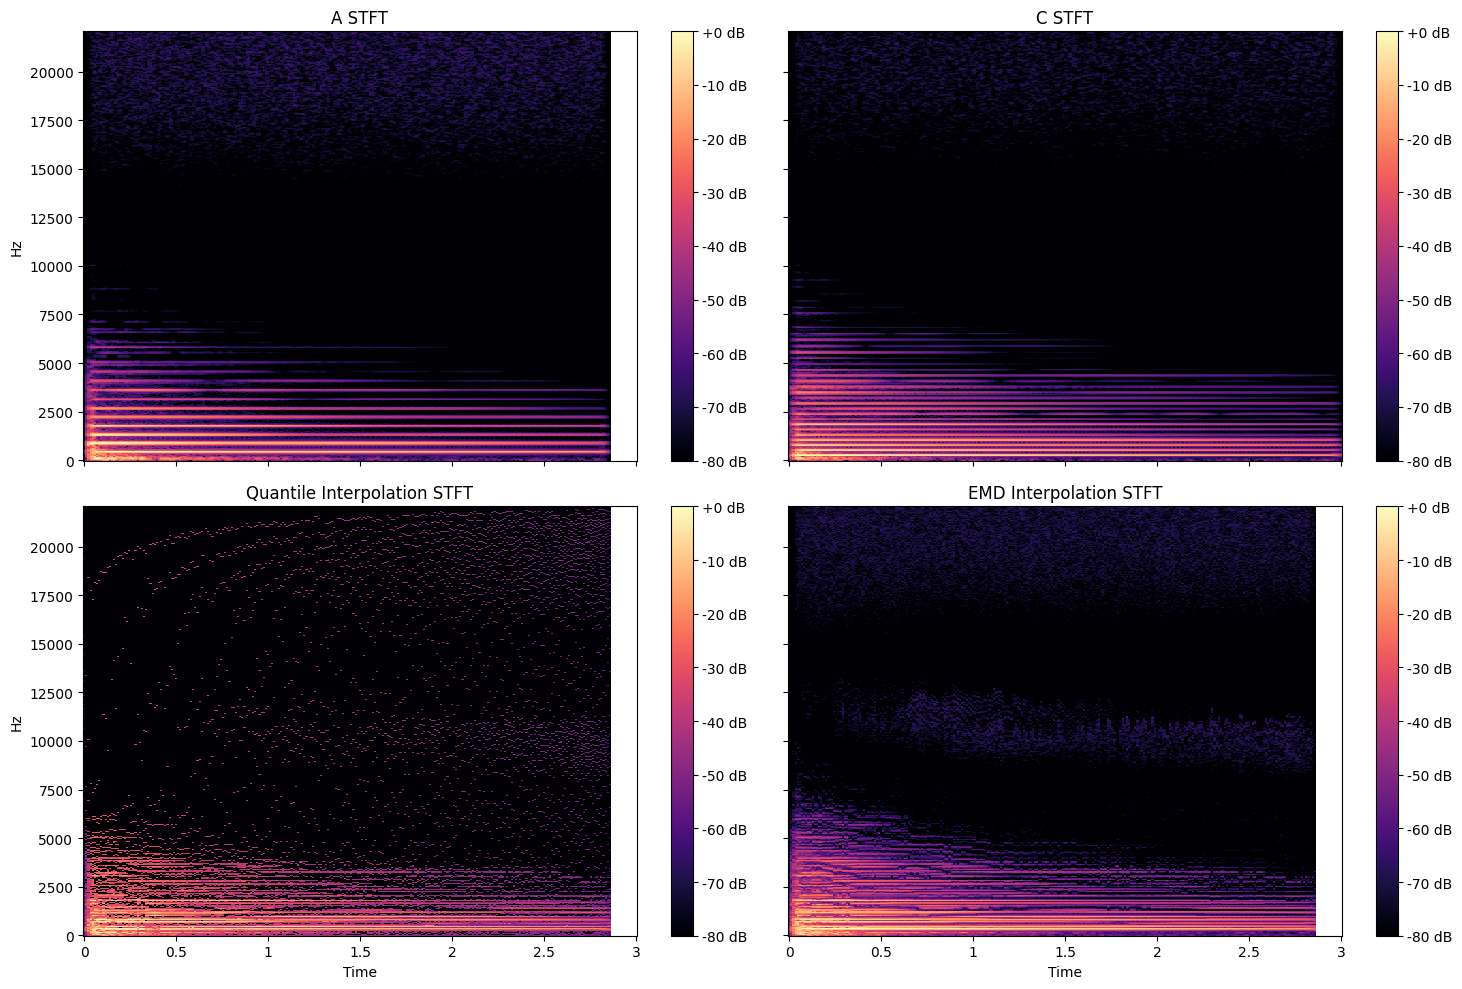

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
titles = ['A STFT', 'C STFT', 'Quantile Interpolation STFT', 'EMD Interpolation STFT']
spectrograms = [A_stft, C_stft, stft_quantile_interpolation, stft_emd_interpolation]

for ax, spectrogram, title in zip(axs.flatten(), spectrograms, titles):
    img = librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                                   ax=ax,
                                   x_axis='time',
                                   y_axis='hz',
                                   sr=sr)
    ax.set_title(title)
    ax.label_outer()
    fig.colorbar(img, ax=ax, format="%+2.0f dB")

plt.tight_layout()
plt.show()


In [27]:
stft_quantile_inversed = librosa.griffinlim(stft_quantile_interpolation, n_iter=100)
stft_emd_inversed = librosa.griffinlim(stft_emd_interpolation, n_iter=100)

fft_signals = [A_signal, C_signal, stft_quantile_inversed, stft_emd_inversed]
fft_titles = ['A', 'C', f'Quantile interpolation - alpha={alpha}', f'EMD interpolation - alpha={alpha}']
audio_widgets = [audio_widget(signal, title) for signal, title in zip(fft_signals, fft_titles)]

grid = widgets.VBox(audio_widgets)
grid

## Generate animations

In [ ]:
# import matplotlib.animation as animation

# max_frequency_index = 5000 # in Hz, for plotting 
# index = np.argmax(fft_frequency > max_frequency_index)

# # Setup figure and axes for the plot
# fig, ax = plt.subplots(figsize=[10, 8])

# # Static plots for A and C
# ax.plot(fft_frequency[:index], A_fft_magnitude[:index], label='A Signal', linewidth=1.5)
# ax.plot(fft_frequency[:index], C_fft_magnitude[:index], label='C Signal', color='red', linewidth=1.5)
# ax.set(xlabel='Frequency (Hz)', ylabel='Normalized Magnitude', title='Interpolation between A and C - Quantile')
# ax.grid(True, which="both", ls="--")
# ax.legend()

# # Placeholder for the quantile interpolation plot, initially not visible
# quantile_line, = ax.plot([], [], label='Quantile', color="orange")

# def update(frame):
#     # Calculate new alpha for this frame
#     alpha = frame / 40.0  # Assuming 40 frames to go from 0 to 1
    
#     # Recalculate quantile interpolation with the new alpha
#     fft_quantile_interpolation = quantile_optimal_transport(A_fft_magnitude, C_fft_magnitude, alpha=alpha)
    
#     # Update the data for the quantile interpolation plot
#     quantile_line.set_data(fft_frequency[:index], fft_quantile_interpolation[:index])
    
#     # Update the title to reflect the current alpha
#     ax.set_title(f'Interpolation between A and C - Quantile - alpha={alpha:.2f}')
    
#     return quantile_line,

# # Create animation
# ani = animation.FuncAnimation(fig=fig, func=update, frames=np.arange(0, 41), interval=100)

# # Save the animation
# ani.save('animations/real/quantile_interpolation.gif')

In [ ]:
# import matplotlib.animation as animation

# # takes around 13 minutes

# max_frequency_index = 5000 # in Hz, for plotting 
# index = np.argmax(fft_frequency > max_frequency_index)

# # Setup figure and axes for the plot
# fig, ax = plt.subplots(figsize=[10, 8])

# # Static plots for A and C
# ax.plot(fft_frequency[:index], A_fft_magnitude[:index], label='A Signal', linewidth=1.5)
# ax.plot(fft_frequency[:index], C_fft_magnitude[:index], label='C Signal', color='red', linewidth=1.5)
# ax.set(xlabel='Frequency (Hz)', ylabel='Normalized Magnitude', title='Interpolation between A and C - EMD')
# ax.grid(True, which="both", ls="--")
# ax.legend()

# emd_line, = ax.plot([], [], label='EMD', color="purple")

# def update(frame):
#     alpha = frame / 40.0  # Assuming 40 frames to go from 0 to 1
    
#     fft_emd_interpolation = emd_optimal_transport(fft_frequency, A_fft_magnitude, C_fft_magnitude, alpha=alpha)
    
#     emd_line.set_data(fft_frequency[:index], fft_emd_interpolation[:index])
    
#     ax.set_title(f'Interpolation between A and C - EMD - alpha={alpha:.2f}')
    
#     return emd_line,

# # Create animation
# ani = animation.FuncAnimation(fig=fig, func=update, frames=np.arange(0, 41), interval=100)

# # Save the animation
# ani.save('animations/real/emd_interpolation.gif')